In [29]:
import numpy as np
import pandas as pd
import nn
import matplotlib.pyplot as plt
import GPy

In [174]:
model_cfg = {
    "batch_size_p" : 0.1,
    "n_epochs" : 500,
    "verbose" : False,
    "n_input" : 4,
    "n_hidden" : 20,
    "n_output" : 3,
    "hidden_activation" : "relu",
    "stochastic" : True,
    "dropout_p" : 0.1,
    "epsilon" : 0.00,
    "n_samples" : 100
}

# load data 
df = pd.read_csv('r490.csv')
df = df[df['r1_charge_heater'] >= 0]

X = np.array(df[['r1_temp', 'r2_temp', 'r1_pressure', 'r2_pressure']])
Y = np.array(df[['r1_charge_heater', 'process_ron', 'process_yield']])

model = nn.FeedforwardNN(model_cfg)


In [175]:
ix = (X[:,1] == 136) & (X[:,2] == 50) & (X[:,3] == 50)
Xtrain = X[ix,:]
Ytrain = Y[ix,:]

In [176]:
model.train(Xtrain, Ytrain)

In [177]:
Xstar = np.array([ [r1t, 136, 50, 50] for r1t in np.linspace(120, 170, 1000)])
preds = model.predict(Xstar, model_cfg['n_samples'])

In [178]:
import scipy.stats as stats

a, b = stats.norm.interval(0.95, np.mean(preds, axis=0), np.std(preds, axis=0))

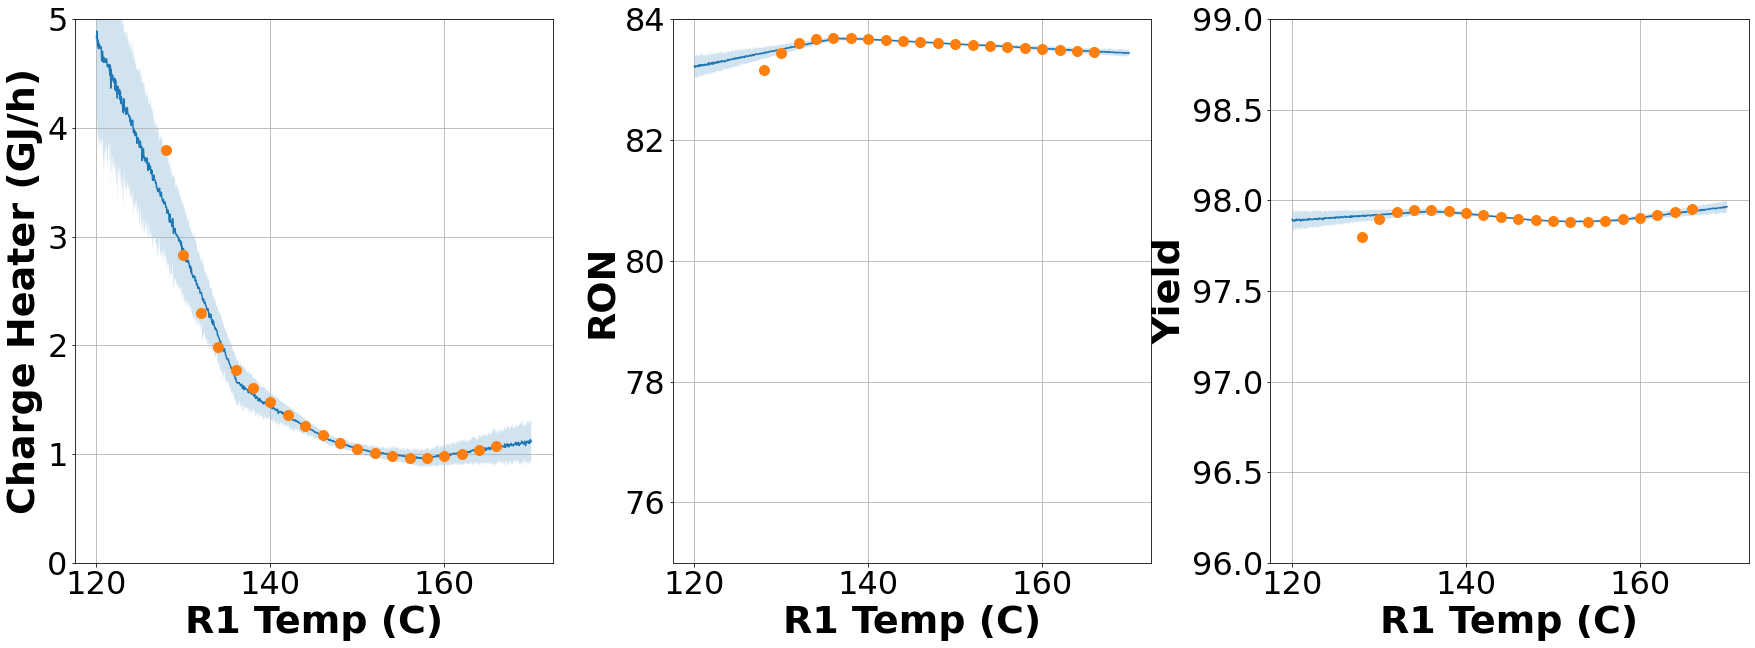

In [179]:
r1temps = np.linspace(120, 170, 1000)

f, axes = plt.subplots(1, 3, figsize=(30, 10))

mu = np.mean(preds, axis=0)

ax = axes[0]
ax.plot(r1temps, mu[:, 0] / 1e6, '-')
ax.fill_between(r1temps, a[:,0]/1e6, b[:,0]/1e6, alpha=0.2)
ax.plot(Xtrain[:, 0], Ytrain[:,0] / 1e6, 'o', markersize=10)
ax.tick_params(axis='x', labelsize=32)
ax.tick_params(axis='y', labelsize=32)
ax.set_xlabel('R1 Temp (C)', fontsize=38, fontweight='bold')
ax.set_ylabel('Charge Heater (GJ/h)', fontsize=38, fontweight='bold')
ax.grid(True)
ax.set_ylim([0, 5])

ax = axes[1]
ax.plot(r1temps, mu[:, 1], '-')
ax.fill_between(r1temps, a[:,1], b[:,1], alpha=0.2)
ax.plot(Xtrain[:, 0], Ytrain[:,1], 'o', markersize=10)
ax.tick_params(axis='x', labelsize=32)
ax.tick_params(axis='y', labelsize=32)
ax.set_xlabel('R1 Temp (C)', fontsize=38, fontweight='bold')
ax.set_ylabel('RON', fontsize=38, fontweight='bold')
ax.grid(True)
ax.set_ylim([75, 84])


ax = axes[2]
ax.plot(r1temps, mu[:, 2], '-')
ax.fill_between(r1temps, a[:,2], b[:,2], alpha=0.2)
ax.plot(Xtrain[:, 0], Ytrain[:,2], 'o', markersize=10)
ax.tick_params(axis='x', labelsize=32)
ax.tick_params(axis='y', labelsize=32)
ax.set_xlabel('R1 Temp (C)', fontsize=38, fontweight='bold')
ax.set_ylabel('Yield', fontsize=38, fontweight='bold')
ax.grid(True)
ax.set_ylim([96, 99])

plt.subplots_adjust(wspace=0.25)

#plt.savefig('tmp/fig9.tiff', bbox_inches='tight', transparent=True, pad_inches=0.05, dpi=300, pil_kwargs={"compression": "tiff_lzw"})


In [170]:
def train_slfm_gp(X, Y):
    n_inputs = X.shape[1]
    n_outputs = Y.shape[1]
    
    print(n_inputs)
    print(n_outputs)
    K = GPy.util.multioutput.LCM(n_inputs, 
                                 n_outputs, 
                                 [GPy.kern.Matern52(n_inputs) for i in range(n_outputs)], 
                                 W_rank=1)
    print(K)  
    m = GPy.models.GPCoregionalizedRegression([X for i in range(n_outputs)], 
                                              [Y[:,[i]] for i in range(n_outputs)],
                                              kernel=K)
        
    m['.*B.*kappa'].constrain_fixed(1.)
    m.optimize()
    return m

m = train_slfm_gp(Xtrain, Ytrain)

4
3
  sum.                    |   value  |  constraints  |  priors
  ICM0.Mat52.variance     |     1.0  |      +ve      |        
  ICM0.Mat52.lengthscale  |     1.0  |      +ve      |        
  ICM0.B.W                |  (3, 1)  |               |        
  ICM0.B.kappa            |    (3,)  |      +ve      |        
  ICM1.Mat52.variance     |     1.0  |      +ve      |        
  ICM1.Mat52.lengthscale  |     1.0  |      +ve      |        
  ICM1.B.W                |  (3, 1)  |               |        
  ICM1.B.kappa            |    (3,)  |      +ve      |        
  ICM2.Mat52.variance     |     1.0  |      +ve      |        
  ICM2.Mat52.lengthscale  |     1.0  |      +ve      |        
  ICM2.B.W                |  (3, 1)  |               |        
  ICM2.B.kappa            |    (3,)  |      +ve      |        


 /home/mmkhajah/venvs/sci/lib/python3.8/site-packages/GPy/kern/src/stationary.py:581: RuntimeWarning:overflow encountered in square
 /home/mmkhajah/venvs/sci/lib/python3.8/site-packages/GPy/kern/src/stationary.py:581: RuntimeWarning:invalid value encountered in multiply
 /home/mmkhajah/venvs/sci/lib/python3.8/site-packages/GPy/kern/src/stationary.py:584: RuntimeWarning:overflow encountered in square
 /home/mmkhajah/venvs/sci/lib/python3.8/site-packages/GPy/kern/src/stationary.py:584: RuntimeWarning:invalid value encountered in multiply
 /home/mmkhajah/venvs/sci/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /home/mmkhajah/venvs/sci/lib/python3.8/site-packages/GPy/kern/src/stationary.py:584: RuntimeWarning:invalid value encountered in subtract


In [171]:
Xstar = np.array([ [r1t, 136, 50, 50] for r1t in np.linspace(120, 170, 1000)])
ones = np.ones(Xstar.shape[0])[:,np.newaxis]
newX = np.vstack([np.hstack([Xstar,ones*i]) for i in range(3)])

noise_dict = {'output_index': newX[:,[-1]].astype(int)}
mu, var = m.predict(newX, Y_metadata=noise_dict)

mu = np.reshape(mu, (3, Xstar.shape[0])).T
var = np.reshape(var, (3, Xstar.shape[0])).T

In [172]:

a, b = stats.norm.interval(0.95, mu, np.sqrt(var))
mu.shape

 /tmp/ipykernel_1439684/2917073360.py:1: RuntimeWarning:invalid value encountered in sqrt


(1000, 3)

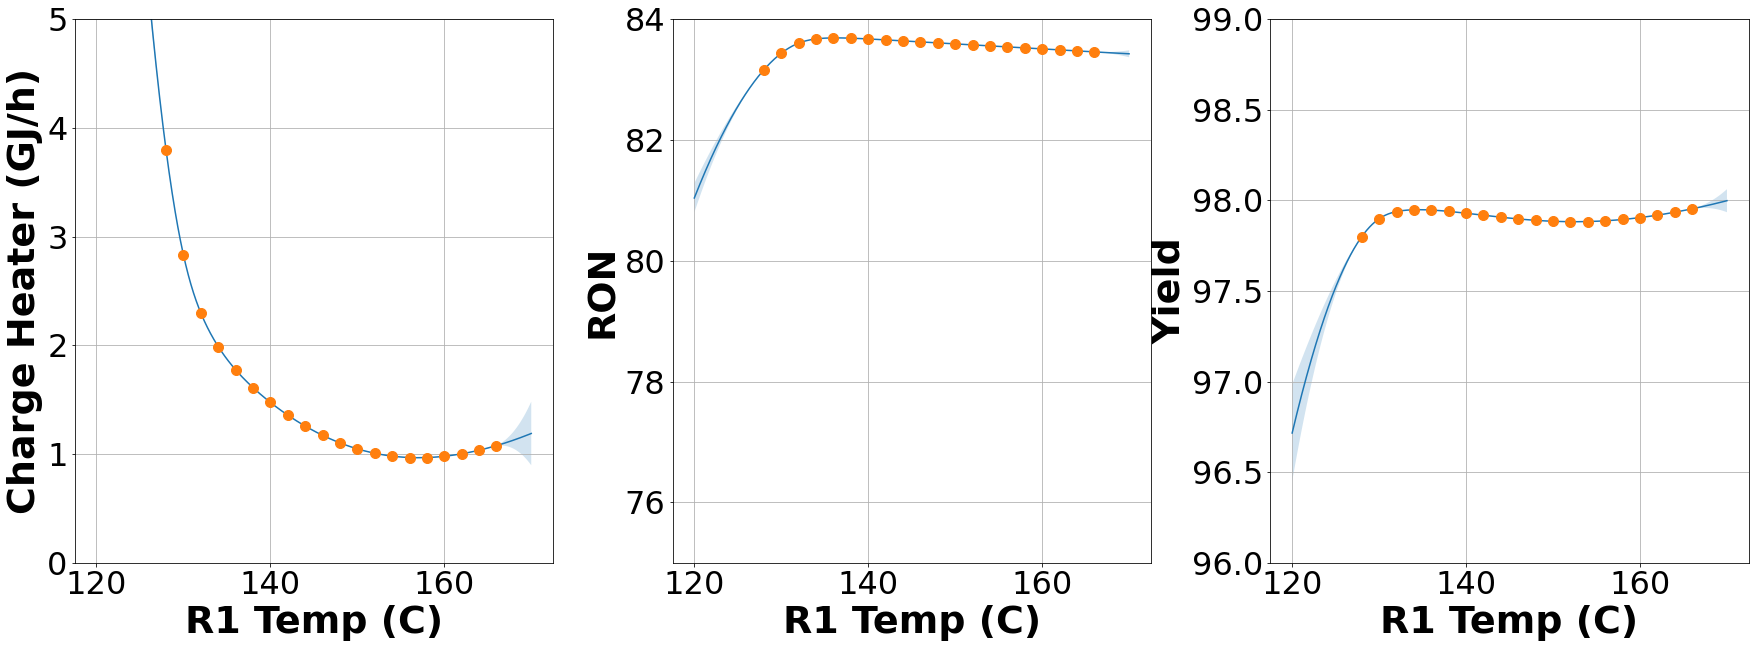

In [173]:
r1temps = np.linspace(120, 170, 1000)

f, axes = plt.subplots(1, 3, figsize=(30, 10))

ax = axes[0]
ax.plot(r1temps, mu[:, 0] / 1e6, '-')
ax.fill_between(r1temps, a[:,0]/1e6, b[:,0]/1e6, alpha=0.2)
ax.plot(Xtrain[:, 0], Ytrain[:,0] / 1e6, 'o', markersize=10)
ax.tick_params(axis='x', labelsize=32)
ax.tick_params(axis='y', labelsize=32)
ax.set_xlabel('R1 Temp (C)', fontsize=38, fontweight='bold')
ax.set_ylabel('Charge Heater (GJ/h)', fontsize=38, fontweight='bold')
ax.grid(True)
ax.set_ylim([0, 5])

ax = axes[1]
ax.plot(r1temps, mu[:, 1], '-')
ax.fill_between(r1temps, a[:,1], b[:,1], alpha=0.2)
ax.plot(Xtrain[:, 0], Ytrain[:,1], 'o', markersize=10)
ax.tick_params(axis='x', labelsize=32)
ax.tick_params(axis='y', labelsize=32)
ax.set_xlabel('R1 Temp (C)', fontsize=38, fontweight='bold')
ax.set_ylabel('RON', fontsize=38, fontweight='bold')
ax.grid(True)
ax.set_ylim([75, 84])


ax = axes[2]
ax.plot(r1temps, mu[:, 2], '-')
ax.fill_between(r1temps, a[:,2], b[:,2], alpha=0.2)
ax.plot(Xtrain[:, 0], Ytrain[:,2], 'o', markersize=10)
ax.tick_params(axis='x', labelsize=32)
ax.tick_params(axis='y', labelsize=32)
ax.set_xlabel('R1 Temp (C)', fontsize=38, fontweight='bold')
ax.set_ylabel('Yield', fontsize=38, fontweight='bold')
ax.grid(True)
ax.set_ylim([96, 99])

plt.subplots_adjust(wspace=0.25)

#plt.savefig('tmp/fig9.tiff', bbox_inches='tight', transparent=True, pad_inches=0.05, dpi=300, pil_kwargs={"compression": "tiff_lzw"})
